<a href="https://colab.research.google.com/github/zypchn/zeytin/blob/main/MedicalRAG_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -qU langchain langchain-pinecone langchain-openai langchain_community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.5/449.5 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5

In [ ]:
import os
import pandas as pd

from getpass import getpass
from pinecone import ServerlessSpec, Pinecone as PineconeClient
from langchain_community.document_loaders import CSVLoader
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_pinecone import PineconeVectorStore
from uuid import uuid4
from langchain import hub
from langgraph.graph import START, END, StateGraph
from typing_extensions import List, TypedDict
from langchain.chat_models import init_chat_model
from IPython.display import Image, display
from langchain.tools import StructuredTool
from pydantic import BaseModel
from langchain_core.tools import tool

In [3]:
os.environ["LANGCHAIN_API_KEY"] = getpass("LANGCHAIN_API_KEY : ")
os.environ["LANGSMITH_API_KEY"] = getpass("LANGSMITH_API_KEY : ")
os.environ["OPENAI_API_KEY"] = getpass("OPENAI_API_KEY : ")
os.environ["PINECONE_API_KEY"] = getpass("PINECONE_API_KEY : ")
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
#notebook_login()

os.environ["LANGSMITH_TRACING_V2"]="true"
os.environ["LANGSMITH_PROJECT"]="zeytin"

LANGCHAIN_API_KEY : ··········
LANGSMITH_API_KEY : ··········
OPENAI_API_KEY : ··········
PINECONE_API_KEY : ··········


In [ ]:
pth = "/content/diagnosis.csv"
loader = CSVLoader(file_path=pth,
                   csv_args={
                       "delimiter": ",",
                       "quotechar": '"',
                       "fieldnames": ["category", "topic", "text", "num_tokens"]
                   })

docs = loader.load()

In [4]:
pc = PineconeClient(api_key=pinecone_api_key)

In [5]:
index_name = "medicalrag-demo"

if not pc.has_index(index_name):
  pc.create_index(
      name=index_name,
      dimension=1536,
      metric="cosine",
      spec=ServerlessSpec(
          cloud="aws",
          region="us-east-1"
      )
  )

index = pc.Index(index_name)

In [6]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [7]:
vector_store = PineconeVectorStore(index=index, embedding=embeddings)

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [ ]:
half_len = len(all_splits) // 2
uuids = [str(uuid4()) for _ in range(len(all_splits))]

try:
  vector_store.add_documents(documents=all_splits[:half_len], ids=uuids[:half_len])
  print("Successfully loaded the first half of the documents.")
  vector_store.add_documents(documents=all_splits[half_len:], ids=uuids[half_len:])
  print("Successfully loaded the second half of the documents.")
except Exception as e:
  print(e)

Successfully loaded the first half of the documents.
Successfully loaded the second half of the documents.


In [ ]:
query = "Kan örneği alınarak yapılan testler hangileridir?"
results = vector_store.similarity_search_with_score(
    query, k=7
)

for res, score in results:
  print(f"SCORE : {score}\n{res.page_content}\n\n")

SCORE : 0.560455322
gibi hücrelerin sayılarak, çeşitli hastalıkların tespitinde kullanılan kan testidir. Hemogram testi ile anlaşılabilen sorunların başında başında enfeksiyon, anemi, bağışıklık sistemi hastalıkları ve kan kanseri gibi hastalıklar gelmektedir. Tam kan Sayımı, CBC, hemogram, diferansiyel ile CBC, TKS isimleriyle de bilinir.Hemogram (Tam Kan Sayımı) Testi Hangi Hastalıkların Tanısı İçin Yapılır?Kişiden kan örneği alınmasıyla yapılan tam kan sayımı (hemogram) testi ile anemi, otoimmün bozukluklar, kemik iliği bozuklukları, dehidrasyon, enfeksiyonlar, iltihaplanma, lösemi, lenfoma, miyeloproliferatif neoplazmlar, miyelodisplastik sendrom, orak hücre hastalığı, talasemi, B12 vitamin, folat ve demir eksikliği gibi vitamin eksiklikleri tespit edilebilir.Tam kan sayımı testinde şu hastalıklar tespit edilir:Hemogram (Tam Kan Sayımı) Testinde Hangi Değerler İncelenir?Test yaptırdıktan sonra size sunulan sonuç sayfanızda yer alan bir dizi alt parametre yer alır. Bu alt parametrel

Checkpoint :
https://python.langchain.com/docs/tutorials/rag/

In [8]:
prompt = hub.pull("rlm/rag-prompt")
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [9]:
class State(TypedDict):
  is_medical: bool
  query: str
  context: List[Document]
  response: str

In [23]:
from typing import Literal

def is_medical_query(state: State):
  """
  Returns 'True' if the query is relevant to medicine, False otherwise.
  """

  prompt = f"""Determine if the following query is related to medicine:
  Query: "{state["query"]}"
  Answer only with 'True' or 'False'"""
  response = llm.invoke(prompt).content.strip().upper()
  if response == "TRUE":
    return {"is_medical": True}
  elif response == "FALSE":
    return {"is_medical": False, "response": "Sorduğunuz konu medikal kapsamda değerlendirilmiyor. Lütfen başka bir soru yazınız."}

In [25]:
def retrieve(state: State):
  retrieved_docs = vector_store.similarity_search(state["query"], k=7)
  return {"context": retrieved_docs}

def generate(state: State):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = prompt.invoke({
      "question": state["query"],
      "context": docs_content,
  })
  response = llm.invoke(messages)
  return {"response": response.content}

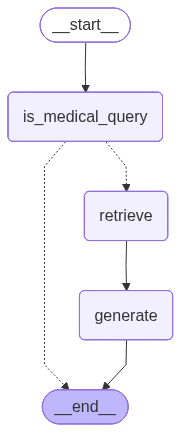

In [26]:
workflow = StateGraph(State)

workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("is_medical_query", is_medical_query)

workflow.add_edge(START, "is_medical_query")
workflow.add_conditional_edges(
    "is_medical_query",
    lambda state: "retrieve" if state["is_medical"] else END,
    {"retrieve": "retrieve", END: END}
)

workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile workflow
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [27]:
query1 = "Kırmızı ve sarı renkler karıştığında hangi renk çıkar?"
query2 = "Kan örneği alınarak yapılan testler hangileridir?"


response1 = app.invoke({
    "query": query1
})

response2 = app.invoke({
    "query": query2
})

print("Non-medical question:")
print(response1["response"])
print()
print("Medical question:")
print(response2["response"])

Non-medical question:
Sorduğunuz konu medikal kapsamda değerlendirilmiyor. Lütfen başka bir soru yazınız.

Medical question:
Kan örneği alınarak yapılan testler arasında hemogram (tam kan sayımı), genetik testler, ELISA testi ve kan gazı testi bulunmaktadır. Hemogram testi, anemi, enfeksiyon ve kan kanseri gibi hastalıkların tespitinde kullanılırken, genetik testler bireylerin genetik yatkınlıklarını belirlemeye yardımcı olur. Ayrıca, kan gazı testi ise vücuttaki asit-baz dengesini değerlendirir.
